# TAL aplicado al análisis del discurso de los medios de prensa 📰🤓🔥


Random forest es un algoritmo de aprendizaje supervisado. Se puede utilizar tanto para clasificación como para regresión. También es el algoritmo más flexible y fácil de usar. Random forest está compuesto por árboles. Se dice que cuantos más árboles tiene, más robusto es un bosque. Random forest crea árboles de decisión sobre muestras de datos seleccionadas al azar, obtienen predicciones de cada árbol y seleccionan la mejor solución mediante votación. También proporciona un indicador bastante bueno de la importancia de la función.



### índex

1. [Importación del dataset](a)
2. [Preprocesamiento y representación vectorial](b)
3. [Entrenamiento del modelo de clasificación](b)
4. [Evaluación del modelo de clasificación](c)

    4.4 [Matriz de confusión](d)


In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [2]:
#NLP
import spacy
nlp = spacy.load("es_core_news_sm")
from spacy.lang.es.stop_words import STOP_WORDS
from spacy.lang.es import Spanish
import string

#SKLEARN
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LogisticRegression # Regresion Logística

# Data manipulation
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from tqdm import tqdm


### 1. Importación del dataset


In [4]:
df = pd.read_csv("topics.csv",sep=',')
df.drop(['Unnamed: 0'], axis = 1, inplace=True) # Para suprimir la columna ID
df['label'].value_counts()

mundo                         10673
deporte                        9609
política y conflictos          9580
salud                          7804
ciencia y tecnología           5689
crimen, delitos y justicia     5564
economía                       1962
cultura y arte                  207
ecología y planeta              172
Name: label, dtype: int64

In [6]:
dfc = df[df['label']!="cultura y arte"]
dfc = dfc[dfc['label']!="ecología y planeta"]
dfc['label'].value_counts()

mundo                         10673
deporte                        9609
política y conflictos          9580
salud                          7804
ciencia y tecnología           5689
crimen, delitos y justicia     5564
economía                       1962
Name: label, dtype: int64

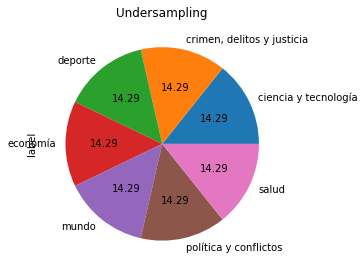

In [9]:
undersample = RandomUnderSampler(random_state=0)
x_res,y_res = undersample.fit_resample(dfc,dfc['label'])
fig, ax = plt.subplots(figsize=(5,5),tight_layout=True)
ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Undersampling")
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x_res['content'],y_res, test_size=0.5)

### 2. Preprocesamiento y representación vectorial

In [11]:
# Create our list of punctuation marks
punctuations = [".",",","!","?", "#","&"]

# Create our list of stopwords
stop_words=[""]

# Load English tokenizer, tagger, parser, NER and word vectors
parser = Spanish()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [word.lower_ for word in mytokens]
        
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [12]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
bow_vector

CountVectorizer(tokenizer=<function spacy_tokenizer at 0x7effe4a8a670>)

In [13]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

### 3. Entrenamiento del modelo de clasificación

In [14]:
from sklearn.ensemble import RandomForestClassifier
modelRF = RandomForestClassifier(random_state=0)

model3 = Pipeline([('preprocessing', bow_vector),
                 ('regression-ML', modelRF)])

# model generation
model3.fit(X_train,y_train)

Pipeline(steps=[('preprocessing',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x7effe4a8a670>)),
                ('regression-ML', RandomForestClassifier(random_state=0))])


### 4. Evaluación del modelo de clasificación


In [15]:
# Predicting with a test dataset
predicted = model3.predict(X_test)
print(predicted)

# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted, 
                                           average='micro'))
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted, 
                                           average='micro'))

['mundo' 'salud' 'crimen, delitos y justicia' ... 'economía' 'salud'
 'crimen, delitos y justicia']
Logistic Regression Accuracy: 0.6028833551769331
Logistic Regression Precision: 0.6028833551769331
Logistic Regression Recall: 0.6028833551769331



### 4.1. Matriz de confusión


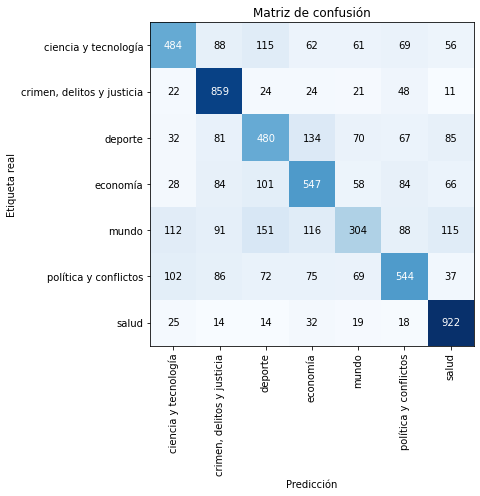

                            precision    recall  f1-score   support

      ciencia y tecnología      0.601     0.518     0.556       935
crimen, delitos y justicia      0.659     0.851     0.743      1009
                   deporte      0.502     0.506     0.504       949
                  economía      0.553     0.565     0.559       968
                     mundo      0.505     0.311     0.385       977
     política y conflictos      0.593     0.552     0.572       985
                     salud      0.714     0.883     0.789      1044

                  accuracy                          0.603      6867
                 macro avg      0.589     0.598     0.587      6867
              weighted avg      0.591     0.603     0.590      6867



In [20]:
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(cm, labels, cmap=plt.cm.Blues):
    fig, ax = plt.subplots(figsize=(7, 7), tight_layout=True)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    for i in range(cm.shape[1]):
        for j in range(cm.shape[0]):
            ax.text(j, i, "{:,}".format(cm[i, j]), 
                    horizontalalignment="center", verticalalignment="center",
                    color="white" if cm[i, j] > np.amax(cm)/2 else "black")
    ax.set_title("Matriz de confusión")
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation='vertical')
    plt.yticks(tick_marks, labels)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Predicción')
    plt.show()

cm = confusion_matrix(y_true=y_test, y_pred=predicted)
plot_confusion_matrix(cm, labels=list(x_res['label'].unique()))
print(classification_report(y_test, predicted, digits=3))